# Feature Engineering

## Time and Lag Features

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from darts import TimeSeries
file_path = "./data/weatherkit_plus_load.csv"  # Update with actual path
df = pd.read_csv(file_path, parse_dates=['event_timestamp'])

df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])
df = df.set_index('event_timestamp').sort_index()

# Extract time-based features
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['day_of_week'] = df.index.dayofweek
df['is_weekend'] = df['day_of_week'] >= 5
df['month'] = df.index.month
df['time_step'] = df['hour'] * 4 + df['minute'] // 15
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['is_peak_time'] = df['time_step'].between(40, 64)
df['is_morning_surge'] = df['time_step'].between(26, 38)

# Shifted time-based features for future covariates
df['hour_fut'] = df['hour'].shift(-96)
df['day_of_week_fut'] = df['day_of_week'].shift(-96)
df['month_fut'] = df['month'].shift(-96)
df['time_step_fut'] = df['time_step'].shift(-96)
df['hour_sin_fut'] = df['hour_sin'].shift(-96)
df['hour_cos_fut'] = df['hour_cos'].shift(-96)
df['is_weekend_fut'] = df['is_weekend'].shift(-96)
df['is_peak_time_fut'] = df['is_peak_time'].shift(-96)
df['is_morning_surge_fut'] = df['is_morning_surge'].shift(-96)

# # Compute lag features
df['lag_1'] = df['load_MW'].shift(1)
df['lag_4'] = df['load_MW'].shift(4)
df['lag_96'] = df['load_MW'].shift(96)
df['lag_672'] = df['load_MW'].shift(672)

# Rolling statistics
df['rolling_mean_4'] = df['load_MW'].rolling(window=4).mean()
# df['rolling_std_4'] = df['load_MW'].rolling(window=4).std()
df['rolling_mean_96'] = df['load_MW'].rolling(window=96).mean()
# df['rolling_std_96'] = df['load_MW'].rolling(window=96).std()
df['rolling_mean_672'] = df['load_MW'].rolling(window=672).mean()
# df['rolling_std_672'] = df['load_MW'].rolling(window=672).std()

# # Historical average from same time 30 days ago (2880 = 96 * 30)
# df['avg_same_slot_30_days_ago'] = df['load_MW'].shift(2880)

# Define observed and forecasted feature sets
observed_features = [
    'weatherkit_observed_temperature_C',
    'weatherkit_observed_humidity_pc',
    'weatherkit_observed_air_pressure_kPa',
    'weatherkit_observed_cloud_cover_pc',
    'weatherkit_observed_wind_speed_km_h'
]

observed_wind_dir = 'weatherkit_observed_wind_direction_deg'

forecasted_features = [
    'weatherkit_forecast_temp_C',
    'weatherkit_forecast_humidity_pc',
    'weatherkit_forecast_air_pressure_kPa',
    'weatherkit_forecast_cloud_cover_pc',
    'weatherkit_forecast_wind_speed_km_h'
]

forecasted_wind_dir = 'weatherkit_forecast_wind_direction_deg'

# Add lag/rolling features for observed weather (excluding wind direction)
for feature in observed_features:
    df[f'{feature}_lag_1'] = df[feature].shift(1)
    df[f'{feature}_lag_4'] = df[feature].shift(4)
    df[f'{feature}_lag_96'] = df[feature].shift(96)
    df[f'{feature}_rolling_mean_4'] = df[feature].rolling(window=4).mean()
    df[f'{feature}_rolling_mean_96'] = df[feature].rolling(window=96).mean()
    df[f'{feature}_rolling_mean_672'] = df[feature].rolling(window=672).mean()

# Add cyclical transforms for wind direction only
df['observed_wind_dir_sin'] = np.sin(np.radians(df[observed_wind_dir]))
df['observed_wind_dir_cos'] = np.cos(np.radians(df[observed_wind_dir]))
df['forecasted_wind_dir_sin'] = np.sin(np.radians(df[forecasted_wind_dir].shift(-96)))
df['forecasted_wind_dir_cos'] = np.cos(np.radians(df[forecasted_wind_dir].shift(-96)))

# Forecasted features: lag_96 simulating known forecast at time t for t+96
for feature in forecasted_features:
    df[f'{feature}_lag_96'] = df[feature].shift(-96)

# 1. Basic time and load features
core_features = [
    'hour_fut', 'day_of_week_fut', 'is_weekend_fut', 'month_fut', 'time_step_fut',
    'hour_sin_fut', 'hour_cos_fut',
    'is_peak_time_fut', 'is_morning_surge_fut',
    'lag_1', 'lag_4', 'lag_96', 'lag_672',
    'rolling_mean_4', 'rolling_mean_96', 'rolling_mean_672',
    'observed_wind_dir_sin', 'observed_wind_dir_cos',
    'forecasted_wind_dir_sin', 'forecasted_wind_dir_cos',
]

# 2. Observed weather lags & rolling
observed_lag_roll = [
    f'weatherkit_observed_{w}_{suffix}'
    for w in ['temperature_C', 'humidity_pc', 'air_pressure_kPa', 'cloud_cover_pc', 'wind_speed_km_h']
    for suffix in ['lag_1', 'lag_4', 'lag_96', 'rolling_mean_4', 'rolling_mean_96', 'rolling_mean_672']
]

# 3. Forecasted weather (lag_96)
forecasted_lag_96 = [
    f'weatherkit_forecast_{w}_lag_96'
    for w in ['temp_C', 'humidity_pc', 'air_pressure_kPa', 'cloud_cover_pc', 'wind_speed_km_h']
]


# Combine all
selected_features = core_features + observed_lag_roll + forecasted_lag_96

# Filter DataFrame
df_selected = df[selected_features].dropna()

# Recreate timestamps and y_df
timestamps = df_selected.index[96:-96]
X_df_filtered = df_selected.loc[timestamps].reset_index()
X_df_filtered.rename(columns={"event_timestamp": "timestamp"}, inplace=True)

y = []
for t in range(96, len(df_selected) - 96):
    y.append(df['load_MW'].iloc[t + 1:t + 97].values)

y_df_filtered = pd.DataFrame(y, columns=[f'load_t+{i+1}' for i in range(96)])
y_df_filtered['timestamp'] = timestamps

pd.set_option('future.no_silent_downcasting', True)
# Step 1: Strip timezone info
X_df_filtered['timestamp'] = pd.to_datetime(X_df_filtered['timestamp']).dt.tz_localize(None)
y_df_filtered['timestamp'] = pd.to_datetime(y_df_filtered['timestamp']).dt.tz_localize(None)

# Step 2: Create full time range and reindex to fill any gaps
full_index = pd.date_range(
    start=X_df_filtered['timestamp'].min(),
    end=X_df_filtered['timestamp'].max(),
    freq='15min'
)

X_df_filtered = X_df_filtered.set_index('timestamp').reindex(full_index).ffill().reset_index().rename(columns={'index': 'timestamp'})
y_df_filtered = y_df_filtered.set_index('timestamp').reindex(full_index).ffill().reset_index().rename(columns={'index': 'timestamp'})

# Step 3: Convert to Darts TimeSeries with proper freq
target_series = TimeSeries.from_dataframe(
    y_df_filtered,
    time_col='timestamp',
    value_cols=[f'load_t+{i+1}' for i in range(96)],
    fill_missing_dates=True,
    freq="15min"
)

covariate_series = TimeSeries.from_dataframe(
    X_df_filtered,
    time_col='timestamp',
    value_cols=[col for col in X_df_filtered.columns if col != 'timestamp'],
    fill_missing_dates=True,
    freq="15min"
)


# Observed and forecasted Features

In [ ]:
from darts.models import LightGBMModel

# Define the model
model = LightGBMModel(
    lags=None,  # no lags on target since it's exogenous
    lags_past_covariates=[-1],
    lags_future_covariates=[0],

    output_chunk_length=96,
    multi_models=True,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
model.fit(
    series=target_series,
    past_covariates=covariate_series,
    future_covariates=covariate_series,
    # verbose=True
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20898
[LightGBM] [Info] Number of data points in the train set: 13313, number of used features: 110
[LightGBM] [Info] Start training from score 372.919958
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20898
[LightGBM] [Info] Number of data points in the train set: 13313, number of used features: 110
[LightGBM] [Info] Start training from score 372.929308
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

In [16]:
model.save("./models/lightgbm_model2.pkl")


In [12]:
from darts.models import LightGBMModel

model = LightGBMModel.load("./models/lightgbm_model.pkl")
from darts.metrics import mape, smape, mae

# Generate historical forecasts
forecast = model.historical_forecasts(
    series=target_series,
    past_covariates=covariate_series,
    future_covariates=covariate_series,
    start=0.7,  # start backtest at 80% of the series length
    forecast_horizon=96,
    stride=96,  # step forward 96 timesteps each time
    retrain=False,  # if True, retrain model at each step
    verbose=True,
    last_points_only=False  # <<< KEY to getting full forecast windows

)


historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/sham/PycharmProjects/LoadPrediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/sham/PycharmProjects/LoadPrediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/sham/PycharmProjects/LoadPrediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/sham/PycharmProjects/LoadPrediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/sham/PycharmProjects/LoadPrediction/.venv/lib/python3.10/site-packages/sklearn/utils/

Number of series components (96) is larger than the maximum number of components to plot (10). Plotting only the first `10` components. You can adjust the number of components to plot using `max_nr_components`.
Number of series components (96) is larger than the maximum number of components to plot (10). Plotting only the first `10` components. You can adjust the number of components to plot using `max_nr_components`.


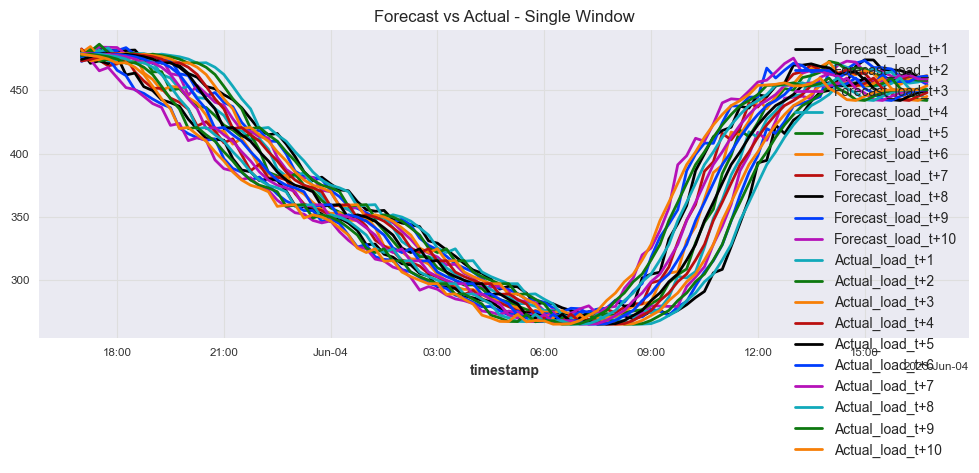

In [13]:
import matplotlib.pyplot as plt

# Get the first forecasted series
single_forecast = forecast[0]

# Get the corresponding actual values for the same time window
actual_window = target_series.slice_intersect(single_forecast)

# Plot
plt.figure(figsize=(12, 4))
single_forecast.plot(label="Forecast")
actual_window.plot(label="Actual")
plt.title("Forecast vs Actual - Single Window")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
import os
os.environ["TQDM_DISABLE"] = "1"


# Assemble X_t and Y_t

In [ ]:
def preprocess_inference_input(current_timestamp: pd.Timestamp,
                                df_history: pd.DataFrame,
                                df_forecast: pd.DataFrame) -> pd.Series:
    """
    Generate a feature vector (X_t) for day-ahead 15-min interval load prediction.

    Parameters:
    - current_timestamp: datetime of prediction
    - df_history: DataFrame containing historical load and observed weather up to current_timestamp
    - df_forecast: DataFrame containing future forecasted weather (must include current_timestamp + 24h)

    Returns:
    - pd.Series: Feature vector for model inference
    """
    t = current_timestamp

    # Time-based features
    hour = t.hour
    time_step = hour * 4 + t.minute // 15
    day_of_week = t.dayofweek
    is_weekend = day_of_week >= 5
    month = t.month
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)
    step_sin = np.sin(2 * np.pi * time_step / 96)
    step_cos = np.cos(2 * np.pi * time_step / 96)
    is_peak_time = 40 <= time_step <= 64
    is_morning_surge = 26 <= time_step <= 38

    # Load lags and rolling means
    lag_1 = df_history['load_MW'].shift(1).loc[t]
    lag_4 = df_history['load_MW'].shift(4).loc[t]
    lag_96 = df_history['load_MW'].shift(96).loc[t]
    lag_672 = df_history['load_MW'].shift(672).loc[t]
    rolling_mean_4 = df_history['load_MW'].rolling(4).mean().loc[t]
    rolling_mean_96 = df_history['load_MW'].rolling(96).mean().loc[t]
    rolling_mean_672 = df_history['load_MW'].rolling(672).mean().loc[t]
    avg_30_days_ago = df_history['load_MW'].shift(2880).loc[t]

    # Observed weather features (lag and rolling mean)
    obs_features = {}
    for f in ['temperature_C', 'humidity_pc', 'air_pressure_kPa', 'cloud_cover_pc', 'wind_speed_km_h']:
        base = f'weatherkit_observed_{f}'
        obs_features[f'{base}_lag_1'] = df_history[base].shift(1).loc[t]
        obs_features[f'{base}_lag_4'] = df_history[base].shift(4).loc[t]
        obs_features[f'{base}_lag_96'] = df_history[base].shift(96).loc[t]
        obs_features[f'{base}_rolling_mean_4'] = df_history[base].rolling(4).mean().loc[t]
        obs_features[f'{base}_rolling_mean_96'] = df_history[base].rolling(96).mean().loc[t]
        obs_features[f'{base}_rolling_mean_672'] = df_history[base].rolling(672).mean().loc[t]

    # Observed wind direction (cyclical)
    wind_obs_deg = df_history['weatherkit_observed_wind_direction_deg'].loc[t]
    obs_wind_sin = np.sin(np.radians(wind_obs_deg))
    obs_wind_cos = np.cos(np.radians(wind_obs_deg))

    # Forecasted weather at t+96 (same time next day)
    t_forecast = t + pd.Timedelta(minutes=96 * 15)
    forecast_features = {}
    for f in ['temp_C', 'humidity_pc', 'air_pressure_kPa', 'cloud_cover_pc', 'wind_speed_km_h']:
        col = f'weatherkit_forecast_{f}'
        forecast_features[f'{col}_lag_96'] = df_forecast[col].loc[t_forecast]

    # Forecasted wind direction (cyclical)
    wind_forecast_deg = df_forecast['weatherkit_forecast_wind_direction_deg'].loc[t_forecast]
    forecast_wind_sin = np.sin(np.radians(wind_forecast_deg))
    forecast_wind_cos = np.cos(np.radians(wind_forecast_deg))

    # Assemble final feature dictionary
    features = {
        'hour': hour,
        'time_step': time_step,
        'day_of_week': day_of_week,
        'is_weekend': is_weekend,
        'month': month,
        'hour_sin': hour_sin,
        'hour_cos': hour_cos,
        'step_sin': step_sin,
        'step_cos': step_cos,
        'is_peak_time': is_peak_time,
        'is_morning_surge': is_morning_surge,
        'lag_1': lag_1,
        'lag_4': lag_4,
        'lag_96': lag_96,
        'lag_672': lag_672,
        'rolling_mean_4': rolling_mean_4,
        'rolling_mean_96': rolling_mean_96,
        'rolling_mean_672': rolling_mean_672,
        'avg_same_slot_30_days_ago': avg_30_days_ago,
        'observed_wind_dir_sin': obs_wind_sin,
        'observed_wind_dir_cos': obs_wind_cos,
        'forecasted_wind_dir_sin': forecast_wind_sin,
        'forecasted_wind_dir_cos': forecast_wind_cos,
    }

    # Add all observed and forecasted weather features
    features.update(obs_features)
    features.update(forecast_features)

    return pd.Series(features)

# Train LightGBM Model

In [16]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load your prepared X_df and y_df from earlier
# (Make sure you have your features and targets reassembled)

# Remove timestamp for modeling
X = X_df.drop(columns=["timestamp"])
y = y_df.drop(columns=["timestamp"])

# Time-based split (no shuffle)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# LightGBM datasets
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

# LightGBM parameters
params = {
    'objective': 'regression_l2',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 64,
    'learning_rate': 0.05,
    'verbosity': -1
}

# Train the model
model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    num_boost_round=1000)

# Predict and evaluate
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val.values.flatten(), y_pred.flatten()))
print(f"Validation RMSE: {rmse:.4f}")

ValueError: DataFrame for label cannot have multiple columns